In [1]:
!pip install neuromancer

In [1]:
import neuromancer
from torch.utils.data import Dataset
from torch.utils.data.dataloader import default_collate
from neuromancer.psl.building_envelope import BuildingEnvelope
import functools
from neuromancer.dataset import DictDataset
from tqdm import tqdm
import random
from torch import tensor
import torch
from neuromancer.psl.signals import signals
import numpy as np
from torch.utils.data import DataLoader
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dynamics.integrators import RK4
from neuromancer.system import Node, System
from neuromancer.constraint import variable
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss
from neuromancer.trainer import Trainer
from neuromancer.loggers import BasicLogger
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import yaml
from dpc_util import simulate, stack_refs, load_stats, remove_key_prefix

In [6]:
# remove problematic signal
if 'beta' in signals:
  del signals['beta']

# set the seed
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Objective
This tutorial demonstrates the use of Blackbox differentiable predictive control (DPC) to learn a constrained neural policy for controlling indoor air temperature in a residential building model. Blackbox DPC is a technique suitable for when there is limited access to the system for which we would like to train a controller. It is a two stage process - first, a Neural State Space Model (NSSM) is trained to approximate the dynamics of the target system, allowing for quick and unlimited access to a surrogate system. Afterward, a controller learns optimal policy over the surrogate system, and we evaluate its performance on the true system.


We begin by making some modifications to `BuildingEnvelope`. We remove `@cast_backend` from `get_q` to enable gradient tracking (this is a bug with the psl systems).

In [7]:
class GradBuildingEnvelope(BuildingEnvelope):
    def __init__(self, device=None, *args, **kwargs):
        self.device=device
        super().__init__(*args, **kwargs)

    def get_q(self, u):
        m_flow = u[0:self.n_mf]
        dT = u[self.n_mf:self.n_mf + self.n_dT]
        q = m_flow * self.rho * self.cp * self.time_reg * dT
        return q

systems = {system: functools.partial(GradBuildingEnvelope, system=system) for system in BuildingEnvelope.systems}

Choose a system.

In [8]:
# supported systems: ['SimpleSingleZone', 'Reno_full']
psl_key = 'SimpleSingleZone'
psl_sys = systems[psl_key]()

# select appropriate device for runtime
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Learning a Neural State Space Model of a SimpleSingleZone

## What is a Neural State Space Model (NSSM)?
An NSSM is a Neural Network that that is trying to replicate a true system or "plant". These can be trained using historical data of interaction in the form of state action tuple pairs $(y_k, u_k, d_k) \rightarrow (y_{k+1})$. For residential buildings, we cannot observe the entire state which influences building dynamics.

![NonAutoODE](figs/nonauto_ODE.png)

This figure is an approximate representation of the NSSM. In it, $\tilde{x}_k$ represents the union of states $y_k$ and $d_k$. The output of the NSSM is $y_k$, not $\tilde{x}_k$.

### Creating a State Space Model
We define a state space model which will learn the dynamics of the building. The model is a Neural Ordinary Differential Equation (NODE).

In [9]:
ny, nu, nd = psl_sys.ny, psl_sys.nU, psl_sys.nD_obs
hsize = 128
nlayers = 2
ssm = blocks.MLP(
    ny + nu + nd,
    ny,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=activations['relu'],
    hsizes=[hsize for _ in range(nlayers)],
)
ssm = RK4(ssm, h=torch.tensor(0.01))
system_node = Node(ssm, ["yn", "U", "D"], ["yn"])
system = System([system_node], name='NSSM').to(device)
system.nstep_key = 'Y'

$ny, nu,$ and $nd$ represent the dimensionality of the observable state, the actions, and the observable disturbances, respectively. For SimpleSingleZone, the values are $ny=1, nu=2,$ and $nd=1$.

## System Identification Problem Setup

To train the state space model for this system, we need a set of constraints and objectives, we will do this by using the `PenaltyLoss` in neuromancer.
The objective function that we use for training these state space models is a reference tracking loss, which penalizes the difference between the predicted state and the true state over the full time sequence.
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \frac{1}{Nm}\sum_{i=1}^m \sum_{k=1}^N ||y^i - \hat{y}^i||_2^2  \\
&\text{subject to}    &&  \hat{y}^i_{k+1} = ODESolve(f_{\theta}(\hat{y}^i_k))
\end{align}
$$  

Where $f$ is parametrized by a neural network with trainable parameters $\theta$, $m$ is the number of simulations, $N$ is the simulation length, $\hat{y}$ denotes the auto-regressively predicted states, and $y_0=\hat{y}_0$.

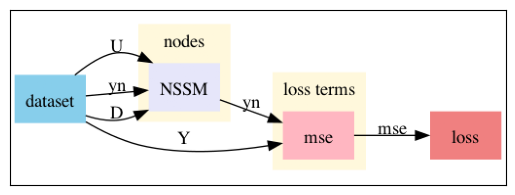

In [6]:
xpred = variable('yn')[:, :-1, :]
xtrue = variable('Y')

loss = (xpred == xtrue) ^ 2
loss.update_name('mse')

obj = PenaltyLoss([loss], [])
problem = Problem([system], obj).to(device)
problem.show()

## Dataset
We will obtain a dataset of simulated trajectories of the system dynamics in the form of input-output-disturbance tuples:
$$\big[({y}^i_0, u^i_0, d^i_0), ..., ({y}^i_N, u^i_N, d^i_N) \big], \, \, i \in [1, ..., m]$$
where $N$ represents the simulation length, $m$ represents number of simulations, and $i$ represents the index of the simulation.
Variables $y_k$ represent observable system states, $d_k$ are system disturbances, and $u_k$ are exogenous inputs at time $k$.

### DictDatasetL

We define a dataset class which can dynamically segment training data. This will allow us to decouple the prediction horizon from the length of the simulation, allowing for flexibility in tuning hyperparameters. It will also allow us to stride over multiple views of the same simulation, increasing data efficiency in cases where our number of observations of the true system is limited.

In [12]:
def remainder(n, d):
    """ use the remainder algorithm to index sequences
    :param i (int) index of subsequence
    """
    i_sim = n // d
    i = n % d
    return i_sim, i

class DictDataset_L(Dataset):
    """
    Basic dataset compatible with neuromancer Trainer
    """

    def __init__(self, datadict, L=32, name='train', stride=1, update_fn=None):
        """

        :rtype: object
        :param datadict: (dict {str: Tensor})
        :param name: (str) Name of dataset
        :param L (int) prediction horizion
        """
        super().__init__()
        self.datadict = datadict
        self.L = L
        self.name = name
        self.nsim, self.nsteps, _ = next(iter(datadict.values())).shape
        self.seqs_per_sim = self.nsteps - self.L + 1
        self.length = (self.nsim * self.seqs_per_sim) // stride
        self.update_fn = update_fn
        self.stride = stride

    def __getitem__(self, i):
        """Fetch a single item from the dataset."""
        i_sim, i = remainder(i * self.stride, self.seqs_per_sim)
        sim_chunk = {k: v[i_sim][i: i+self.L] for k, v in self.datadict.items()}
        if self.update_fn:
            self.update_fn(sim_chunk)
        return sim_chunk

    def __len__(self):
        return self.length

    def collate_fn(self, batch):
        """Wraps the default PyTorch batch collation function and adds a name field.

        :param batch: (dict str: torch.Tensor) dataset sample.
        """
        batch = default_collate(batch)
        batch['name'] = self.name
        return batch

 We normalize $(y, u, d)$ based on saved normalization constants.

In [13]:
NV = load_stats(psl_sys, psl_key)
NVD = {k: v.to(device) for k, v in NV.items()}

We define the function for generating the dataset, as well as functions for using the normalization constants previously loaded.

In [85]:
def denorm(x, key, cpu=True):
  normer = NV if cpu else NVD
  return normer[f'{key}_min'] + (normer[f'{key}_max'] - normer[f'{key}_min']) * (x+1)/2

def norm(x, key, cpu=True):
  normer = NV if cpu else NVD
  return 2 * (x - normer[f'{key}_min']) / (normer[f'{key}_max'] - normer[f'{key}_min']) - 1

def get_dataset(name, nsim=20, nsteps=3500, L=512, stride=509, device='cpu'):
    data = simulate(psl_sys, NV, nsim=nsim, nsteps=nsteps)
    def update_yn(d):
        d['yn'] = d['Y'][0:1, :].clone().detach().requires_grad_(True)

    if name == 'train':
        return DictDataset_L(
            {
                'Y': norm(data['Y'], 'Y').to(device),
                'U': norm(data['U'], 'U').to(device),
                'D': norm(data['D'], 'D').to(device)
            },
            name=name,
            update_fn=update_yn,
            L=L,
            stride=stride
        )
    else:
        return DictDataset(
            {
                'yn': norm(data['Y'][:, 0:1, :], 'Y'),
                'Y': norm(data['Y'], 'Y').to(device),
                'U': norm(data['U'], 'U').to(device),
                'D': norm(data['D'], 'D').to(device)
            },
            name=name
        )

Finally, we initialize a training and development dataset.

In [86]:
train_data = get_dataset('train', nsim=100, device=device)
dev_data = get_dataset('dev', nsim=20, device=device)

Building data...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.03it/s]


We can take a look at what one of these simulations would look like. On the left the temperature of the building is shown, and on the right the controls which influenced that temperature are shown.

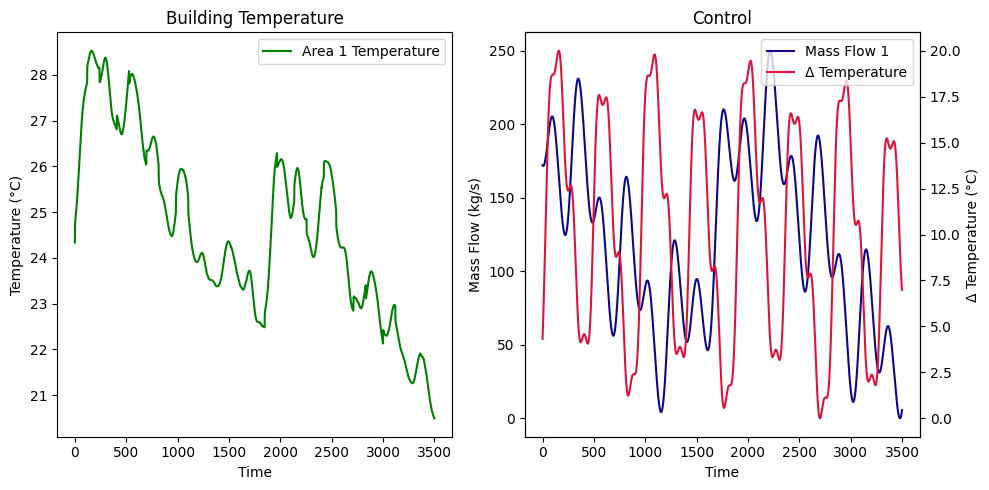

In [87]:
num_colors = 6
pred_colors = [plt.cm.winter(i / num_colors) for i in range(num_colors)]
target_colors = [plt.cm.ocean(i / num_colors) for i in range(num_colors)]
control_colors = [plt.cm.plasma(i / num_colors) for i in range(num_colors)]


sample_control = denorm(train_data.datadict['U'][0].cpu(), key='U').numpy()
sample_sim = denorm(train_data.datadict['Y'][0].cpu(), key='Y').numpy()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for v in range(sample_sim.shape[1]):
  axs[0].plot(sample_sim[:, v], label=f'Area {v+1} Temperature', color=target_colors[v])
axs[0].set_title('Building Temperature')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature (°C)')
axs[0].legend()

lns = []
for v in range(sample_control.shape[1] - 1):
    ln = axs[1].plot(sample_control[:, v], label=f'Mass Flow {v+1}', color=control_colors[v])[0]
    lns.append(ln)

axs[1].set_title('Control')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Mass Flow (kg/s)')


ax2 = axs[1].twinx()
lns.append(ax2.plot(sample_control[:, -1], label='Δ Temperature', color='crimson')[0])
ax2.set_ylabel('Δ Temperature (°C)')

labs = [ln.get_label() for ln in lns]
ax2.legend(lns, labs, loc=1)

plt.tight_layout()
plt.show()

Initialize some dataloaders. These will be used in the Training step.

In [48]:
train_loader = DataLoader(
    train_data,
    batch_size=128,
    collate_fn=train_data.collate_fn,
    shuffle=True
)

dev_loader = DataLoader(
    dev_data,
    batch_size=128,
    collate_fn=dev_data.collate_fn,
    shuffle=False
)

## Train the NSSM
Neuromancer's`trainer` to take care of all of the optimzation boilerplate, once we have defined our problem class, our data, and our optimizer.
Once training is complete we want to take the best model that the trainer produced (estimated by minimal dev loss), and load its state dict.

In [49]:
logger = BasicLogger(savedir='ssm_out', stdout=['train_loss', 'dev_loss'], verbosity=1)

# initialize optimizer and trainer
opt = optim.Adam(system.parameters(), 1e-3)
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=opt,
    epochs=20,
    patience=10,
    logger=logger,
    train_metric="train_loss",
    eval_metric="dev_loss",
    lr_scheduler=True,
    device=device
)

None
Number of parameters: 17281


In [50]:
# train the model
best_model = trainer.train()
trainer.model.load_state_dict(best_model)
problem.to("cpu")

epoch: 0	train_loss: 0.06508	dev_loss: 0.27703	eltime:  16.20673
epoch: 1	train_loss: 0.05168	dev_loss: 0.25799	eltime:  24.30626
epoch: 2	train_loss: 0.04119	dev_loss: 0.06849	eltime:  31.06469
epoch: 3	train_loss: 0.03505	dev_loss: 0.05206	eltime:  37.71230
epoch: 4	train_loss: 0.04594	dev_loss: 0.06991	eltime:  44.72056
epoch: 5	train_loss: 0.03480	dev_loss: 0.03751	eltime:  51.55461
epoch: 6	train_loss: 0.03317	dev_loss: 0.03702	eltime:  58.31630
epoch: 7	train_loss: 0.02471	dev_loss: 0.03033	eltime:  65.45061
epoch: 8	train_loss: 0.03337	dev_loss: 0.02540	eltime:  73.20950
epoch: 9	train_loss: 0.03065	dev_loss: 0.02505	eltime:  81.08034
epoch: 10	train_loss: 0.02884	dev_loss: 0.02464	eltime:  88.62323
epoch: 11	train_loss: 0.02657	dev_loss: 0.02610	eltime:  96.11140
epoch: 12	train_loss: 0.03250	dev_loss: 0.02700	eltime:  103.83579
epoch: 13	train_loss: 0.03872	dev_loss: 0.02581	eltime:  111.25135
epoch: 14	train_loss: 0.02300	dev_loss: 0.02705	eltime:  118.38859
epoch: 15	train_l

### MODEL SUMMARY ###

nodeS:
  System(
  (nodes): ModuleList(
    (0): node_1(yn, U, D) -> yn
  )
)

CONSTRAINTS: none

OBJECTIVES:
  Constraint(
  (left): slice
  (right): Y
  (comparator): Eq()
)

## Evaluation

Now that we have trained the NSSM, we can visualize its accuracy by comparing the output $\hat{y}$ it to the reference $y$.

In [90]:
# evaluate the system
test_data_dict = get_dataset('test', nsim=5).datadict
system_node.eval()
test_out = system(test_data_dict)

# discard last predicted state
test_out['yn'] = test_out['yn'][:, :-1, :]

Building data...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


<Figure size 640x480 with 0 Axes>

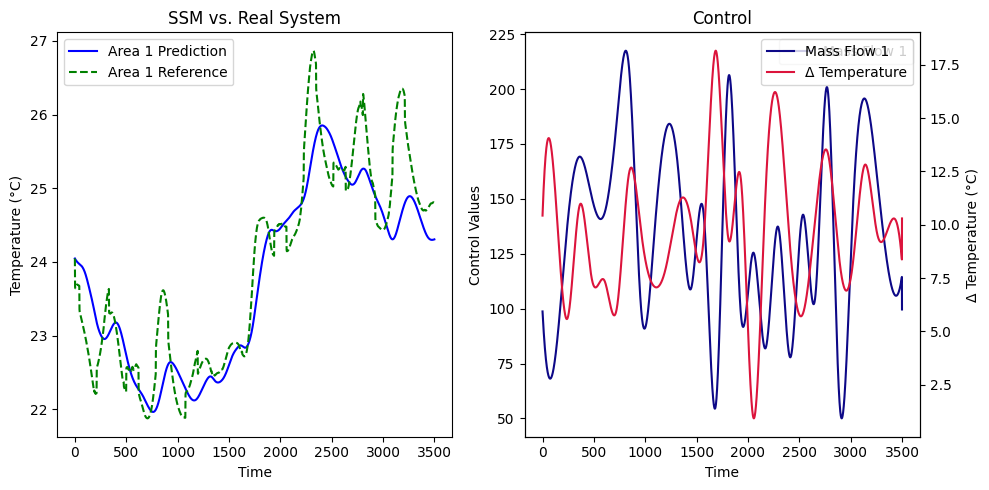

In [95]:
import matplotlib.pyplot as plt

def plot_sysid(data, sim=0):
    plt.clf()
    plot = {}
    for key in data:
        norm_key = 'Y' if key == 'yn' else key
        plot[key] = denorm(data[key], norm_key).detach().cpu().numpy()

    sample_pred = plot["yn"][sim, :, :]
    sample_target = plot["Y"][sim, :, :]
    sample_control = plot["U"][sim, :, :]

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    for v in range(sample_pred.shape[1]):
      axs[0].plot(sample_pred[:, v], label=f'Area {v+1} Prediction', color=pred_colors[v])
      axs[0].plot(sample_target[:, v], label=f'Area {v+1} Reference', color=target_colors[v], linestyle='--')

    axs[0].set_title("SSM vs. Real System")
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("Temperature (°C)")
    axs[0].legend()

    lns = []
    for v in range(sample_control.shape[1] - 1):
        ln = axs[1].plot(sample_control[:, v], label=f'Mass Flow {v+1}', color=control_colors[v])[0]
        lns.append(ln)
    
    axs[1].set_title('Control')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Mass Flow (kg/s)')
    
    
    ax2 = axs[1].twinx()
    lns.append(ax2.plot(sample_control[:, -1], label='Δ Temperature', color='crimson')[0])
    ax2.set_ylabel('Δ Temperature (°C)')
    
    labs = [ln.get_label() for ln in lns]
    ax2.legend(lns, labs, loc=1)

    axs[1].set_title('Control')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Control Values')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


plot_sysid(test_out, sim=2)

# Control
## Dataset
Our dataset is comprised of initial conditions and time-varying temperature bounds. Over time the bounds
periodically jump between a tighter, occupied-period bounds of 22$^\circ$C-24$^\circ$C, and looser, unoccupied-period bounds of 18$^\circ$C-24.4$^\circ$C, alternating with a fixed probability of 0.0005 per timestep. The initial state of the
system is uniformly randomly sampled between historical recorded min and max values, the same ones used for normalization. Let $C_k$ denote a pair of values: the lower ($C^{(\ell)}$) and upper bounds ($C^{(u)}$) at time $k$. 

In [55]:
def sample_min_max(
        nsim=20,
        prob=0.0005,
        bounds=[(20, 22), (18, 24.4)],
        nsteps=3500
        ):
    """
    :param growth_rate: (float) The rate at which the cumulative probability grows at each timestep. Default is 0.00001.
    :param max_prob: (float) The maximum probability value for changing the bounds. Default is 0.5.
    :param bounds: (list[tuple[float, float]]) A list of tuples where each tuple has two float values that represent the bounds. Default is [(20, 22), (18, 24.4)].

    :return: (numpy.ndarray) A 3D array with shape (nsim, nsteps, 2). The last dimension contains the min and max bounds respectively for each timestep in the simulation.
    """
    y_min_list = []
    y_max_list = []

    for _ in range(nsim):
        current_bound_index = random.randint(0, 1)
        y_min = np.full((nsteps,), bounds[current_bound_index][0], dtype=np.single)
        y_max = np.full((nsteps,), bounds[current_bound_index][1], dtype=np.single)

        for t in range(nsteps):
            if random.random() < prob:
                current_bound_index = 1 - current_bound_index
                y_min[t:] = bounds[current_bound_index][0]
                y_max[t:] = bounds[current_bound_index][1]

        y_min_list.append(y_min)
        y_max_list.append(y_max)
    y_min_3d = np.expand_dims(np.stack(y_min_list), axis=2)
    y_max_3d = np.expand_dims(np.stack(y_max_list), axis=2)
    return np.concatenate([y_min_3d,y_max_3d], axis=2)

We define functions to generate the conditions necessary for running and evaluating control. The bound lookahead $p$ specifies the number of timesteps into the future that our policy takes into account for the bounds.

In [57]:
bound_lookahead = 3

def get_control_dataset(name, nsim=20, nsteps=3500, device='cpu'):
    data = simulate(psl_sys, NV, nsim=nsim, nsteps=nsteps)
    refs = sample_min_max(nsim=nsim, nsteps=nsteps)

    data['Y'] = data['Y'][:, 0:1, :]
    data['LB'] = refs[:, :, 0:1]
    data['UB'] = refs[:, :, 1:2]

    bs = data['LB'].shape[0]
    ep_len = data['LB'].shape[1]

    return DictDataset({
            'yn': norm(data['Y'][:, 0:1, :], key='Y').to(device),
            'D': norm(data['D'], key='D').to(device),
            'LB': norm(stack_refs(data['LB'], forecast=bound_lookahead),
                                key='Y').to(device),
            'UB': norm(stack_refs(data['UB'], forecast=bound_lookahead),
                                key='Y').to(device),
            'LB_dn': stack_refs(data['LB'], forecast=bound_lookahead).to(device),
            'UB_dn': stack_refs(data['UB'], forecast=bound_lookahead).to(device),
            'xn_dn': data['X'][:, 0:1, :].to(device),
            'Dhidden_dn': data['Dhidden'].to(device)
        },
        name=name
    )

Now, we can generate the datasets.

In [59]:
train_data = get_control_dataset('train', nsim=64, device=device)
dev_data = get_control_dataset('dev', nsim=16, device=device)

Building data...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.21it/s]


Finally, define the dataloaders to be used by the `Trainer`.

In [60]:
train_loader = DataLoader(
    train_data,
    batch_size=64,
    collate_fn=train_data.collate_fn,
    shuffle=True
)

dev_loader = DataLoader(
    dev_data,
    batch_size=64,
    collate_fn=dev_data.collate_fn,
    shuffle=False
)


## Policy Inputs and Outputs
Our control policy $\pi_\phi$ will be an MLP with parameters $\phi$, that produces control outputs given the observable state, disturbances, and bounds:
$$\pi_\phi = (y_k, d_k, C_{k:k+p}) \rightarrow (u_k).$$
For convenience we denote the sequence of time bounds from $k$ to $k+p$, inclusive, as follows: $C_{k:k+p} = C_k, C_{k+1}, \dots, C_{k+p}$. Our bound lookahead is relatively short, at $p=3$ timesteps. This means that our policy will not have time to plan for expected bounds hours in advance, but is given some leeway to react to imminent changes. 

In [10]:
hsize = 128
nlayers = 2

policy = blocks.MLP_bounds(
    insize=ny + bound_lookahead * 2 + nd,
    outsize=nu,
    hsizes=[hsize for _ in range(nlayers)],
    nonlin=activations['relu'],
    linear_map=torch.nn.Linear,
    min=-1.,
    max=0.
).to(device)

As described in the following section, our policy will will aim to minimize the sum of three components: the energy usage of the control, the difference between consecutive controls, and the constraint violation penalty. Of these elements, the constraint violation penalty is weighted the highest, to ensure proper temperatures above all.

## DPC Problem Formulation  
We learn the neural control policy by solving the following parametric optimal control problem:
$$
\begin{align}
&\underset{\phi}{\text{minimize}}     &&     \mathcal{L}(u_{1:N}^{1:m}, x_{1:N}^{1:m}) = \frac{1}{Nm} \sum_{i=1}^m \sum_{k=1}^{N} \big(E(u_k^i) + \Delta U(u_k^i, u_{k-1}^i) + c(y_k^i)\big), \\
&\text{subject to}                     && u_k^i = \pi_{\phi}(y_k^i, d^i_k, C^i_{k:k+p}) \\
%&                     && \Delta U(u_k, u_{k-1}) = \frac{||\tilde{u}_k-\tilde{u}_{k-1}||_1}{N_u} \in [0,1],\\
%&                     && c_z(y) =
%\begin{cases}
%  0 & \text{if } C_\ell \leq y_z \leq C_u \\
% y_z-C_u & \text{if } y_z>C_u \\
%  C_\ell -y_z & \text{if } y_z<C_\ell
%\end{cases} \\
%&                     && y^i_0 \sim \mathcal{P}_{y_0} \\
%&                     && C \sim  \mathcal{P}_C &&
\end{align}
$$  


The objective function is to minimize a loss function comprised of three components: the energy cost of an action $E(u)$, the action stability penalty $\Delta U(u, u_{prev})$, and the constraint violation penalty $c_z(y)$, which are defined as follows:
### Energy Penalty $E(u)$
Let $q_z(u)$ denote the energy consumption $q_z$ of an individual zone $z$ upon taking action $u$. Quantity $q_z(u)$ is defined to be:
\begin{equation}
    q_z(u) = \rho c \tau_r u_{boiler} u_z,
\end{equation}
where $\rho=0.997$ is the density of water, $c=4.186$ is the specific heat capacity of water, $\tau_r=1/3600$ is the time regularization factor, $u_{boiler}$ is the boiler temperature in Celcius, and $u_z$ is the mass flow to zone $z$. The total energy $Q(u)$ of action $u$ is the sum of individual zone heat-flow energies $q_z$:
\begin{equation}
    Q(u) = \sum_{z}q_{z}(u).
\end{equation}
Finally, the energy usage term $E(u)$ is defined to be:
$$E(u) = \frac{Q(u)-Q(u_{min})}{Q(u_{max})-Q(u_{min})} \in [0,1].$$
That is, $E(u)$ is $Q(u)$ normalized such that the minimum allowable value is $0$ and the maximum is $1$. 

In the notebook code, $E(u)$ is denoted as `Q`, as the unnormalized version of `Q` makes no appearance. We define a function `u2q`, which gets $Q(u)$ from the control action $u$ and normalizes it into $E(u)$.

In [14]:
losses = []

q = variable('Q')

# loss defined as difference from zero, L1 loss
energy_loss = (q == torch.tensor(0.).to(device))
energy_loss.update_name('energy_loss')
losses.append(energy_loss)

q_min = torch.sum(psl_sys.get_q(NV['U_min']))
q_max = torch.sum(psl_sys.get_q(NV['U_max']))

def u2q(U):
    norm_u = denorm(U, key='U', cpu=False).permute(1, 0)
    denorm_q = torch.sum(psl_sys.get_q(norm_u), dim=0, keepdim=True)
    norm_q = (denorm_q - q_min) / (q_max - q_min)
    return norm_q.permute(1, 0)

q_node = Node(
    u2q,
    ['U'], ['Q'],
    name='U2Q'
)

### Action Penalty $\Delta U(u_k, u_{k-1})$

The action stability penalty is defined to be:
$$\Delta U(u_k, u_{k-1}) = \frac{||\tilde{u}_k-\tilde{u}_{k-1}||_1}{n_u} \in [0,1].$$ 
It is the average absolute distance between the action taken at the previous time step and the action taken at the current time step, averaged over the $n_u$-dimensional control vector.

In [15]:
u = variable('U')

# loss defined as difference between adjacent controls
stability_loss = ((u[:,:-1,:] - u[:,1:,:]) == torch.tensor(0.).to(device))
stability_loss.update_name('stability_loss')
losses.append(stability_loss)

### Constraint Violation Penalty $c(y)$

The per-zone constraint violation penalty, for zone $z$, based on its temperature $y_z$ is defined to be:
$$c_z(y_z) =
\begin{cases}
  0 & \text{if } C^{(\ell)} \leq y_z \leq C^{(u)} \\
  y_z-C^{(u)} & \text{if } y_z>C^{(u)} \\
  C^{(\ell)} -y_z & \text{if } y_z<C^{(\ell)}
\end{cases}.$$

if the zone temperature  is within the bounds, the penalty is zero. For all temperatures outside of the bounds, the penalty is equal to the difference between the temperature and the nearest bound. 

The overall constraint violation penalty $c(y)$ is simply the sum of the per-zone violation terms:
$$ c(y) = \sum_z c_z(y_z) $$

This can be implemented easily in neuromancer using constraints:

In [16]:
pred = variable('yn_dn')

ub = variable('UB_dn')
lb = variable('LB_dn')

# loss defined as aggregate of upper bound violation and lower bound violation
# losses are multiplied by the number of areas to sum their violations
state_upper_bound_penalty = float(ny) * (pred < ub[:, :, 0:1])
state_lower_bound_penalty = float(ny) * (pred > lb[:, :, 0:1])

constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty
]

## Constructing the System and Problem
Now, initialize the control system. We will need to wrap the policy in a `Node`. We will also create a `Node` to denormalize the output of our NSSM.

In [17]:
denormnode = Node(
    lambda u, yn: (
    denorm(u, key='U', cpu=False), denorm(yn, key='Y', cpu=False)),
    ['U', 'yn'], ['U_dn', 'yn_dn'],
    name='denorm'
)

policy_node = Node(policy, ['yn', 'D', 'UB', 'LB'], ['U'], name='policy')

system_node.eval()
control_system = System([policy_node, system_node, q_node, denormnode], name='control_system')
control_system.nstep_key = 'UB'
control_system.to(device)

System(
  (nodes): ModuleList(
    (0): policy(yn, D, UB, LB) -> U
    (1): node_1(yn, U, D) -> yn
    (2): U2Q(U) -> Q
    (3): denorm(U, yn) -> U_dn, yn_dn
  )
)

Finally, we construct the problem.

In [ ]:
obj = PenaltyLoss(losses, constraints)
problem = Problem([control_system], obj)

## Training
We define a `Trainer` and train the model, optimizing only the policy's parameters.

In [ ]:
logger = BasicLogger(savedir='policy_out', stdout=['train_loss', 'dev_loss'], verbosity=1)
opt = optim.Adam(policy.parameters(), 1e-3)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=opt,
    epochs=10,
    patience=5,
    train_metric="train_loss",
    eval_metric="dev_loss",
    lr_scheduler=True,
    device=device,
    logger=logger
)

None
Number of parameters: 35203


In [ ]:
best_model = trainer.train()
trainer.model.load_state_dict(best_model)
problem.to('cpu')

epoch: 0	train_loss: 1.01719	dev_loss: 0.69377	eltime:  58.45421
epoch: 1	train_loss: 1.03580	dev_loss: 0.61377	eltime:  121.39517
epoch: 2	train_loss: 0.77236	dev_loss: 0.54001	eltime:  179.03400
epoch: 3	train_loss: 0.66235	dev_loss: 0.47133	eltime:  239.42580
epoch: 4	train_loss: 0.69400	dev_loss: 0.41431	eltime:  295.89100
epoch: 5	train_loss: 0.65400	dev_loss: 0.38083	eltime:  347.23528
epoch: 6	train_loss: 0.51811	dev_loss: 0.37655	eltime:  397.51059
epoch: 7	train_loss: 0.59346	dev_loss: 0.38633	eltime:  447.81024
epoch: 8	train_loss: 0.53324	dev_loss: 0.40374	eltime:  498.55043
epoch: 9	train_loss: 0.57766	dev_loss: 0.41694	eltime:  556.85612
epoch: 10	train_loss: 0.50698	dev_loss: 0.41857	eltime:  617.80521
epoch: 11	train_loss: 0.53812	dev_loss: 0.41059	eltime:  667.09488
epoch: 12	train_loss: 0.52587	dev_loss: 0.39512	eltime:  717.78969
epoch: 13	train_loss: 0.58826	dev_loss: 0.37556	eltime:  767.31070
epoch: 14	train_loss: 0.48738	dev_loss: 0.35889	eltime:  817.25062
epoch:

### MODEL SUMMARY ###

nodeS:
  System(
  (nodes): ModuleList(
    (0): policy(yn, D, UB, LB) -> U
    (1): node_1(yn, U, D) -> yn
    (2): U2Q(U) -> Q
    (3): denorm(U, yn) -> U_dn, yn_dn
  )
)

CONSTRAINTS:
  Constraint(
  (left): yn_dn
  (right): slice
  (comparator): GT()
)
  Constraint(
  (left): yn_dn
  (right): slice
  (comparator): LT()
)

OBJECTIVES:
  Constraint(
  (left): Q
  (right): Q_zero
  (comparator): Eq()
)
  Constraint(
  (left): -
  (right): U_zero
  (comparator): Eq()
)

## Evaluation
### Define Test System
We define a seperate test system for evaluation. This system uses the true system, `psl_sys_t`, instead of the NSSM `system_node`. We must also modify our normalization functions, as the true system operates in unnormalized space while the NSSM operates in normalized space.

In [64]:
def test_u2q(U):
    norm_u = denorm(U, key='U').permute(1, 0)
    denorm_q = torch.sum(psl_sys.get_q(norm_u), dim=0, keepdim=True)
    norm_q = (denorm_q - q_min) / (q_max - q_min)
    return norm_q.permute(1, 0)

test_q_node = Node(
    test_u2q,
    ['U'], ['Q'],
    name='U2Q'
)

test_denormnode = Node(
    lambda u:
    denorm(u, key='U'),
    ['U'], ['U_dn'],
    name='denorm'
)

test_normnode = Node(
    lambda yn: norm(yn, key='Y'),
    ['yn_dn'], ['yn'],
    name='norm'
)

### Evaluate Notebook or Pretrained Policy
The policy trained earlier will likely have poor performance, as a good policy for this problem typically takes longer to train. Set `use_pretrained` to `True` to load and evaluate a pre-trained model with good performance, or to `False` to use the policy trained above.

In [65]:
use_pretrained = True

if use_pretrained:
    file_root = f'models/blackbox/{psl_key}'
    with open(os.path.join(file_root, 'config.yaml'), 'r') as yaml_file:
      cfg = yaml.unsafe_load(yaml_file)
    hsize = cfg.policy_hsize
    nlayers = cfg.policy_nlayers
    act = cfg.policy_act

    pt_policy = blocks.MLP_bounds(
        insize=ny + bound_lookahead * 2 + nd,
        outsize=nu,
        hsizes=[hsize for _ in range(nlayers)],
        nonlin=activations[act],
        linear_map=torch.nn.Linear,
        min=-1.,
        max=0.
    )

    problem_state_dict = torch.load(os.path.join(file_root, 'best_model_state_dict.pth'), map_location=torch.device('cpu'))

    pt_policy_node = Node(pt_policy, ['yn', 'D', 'UB', 'LB'], ['U'], name='policy')
    pt_policy_node.load_state_dict(remove_key_prefix(problem_state_dict, 'nodes.0.nodes.0.'))
    test_policy_node = pt_policy_node
else:
    test_policy_node = policy_node

psl_sys_t = systems[psl_key](backend='torch')
test_system_node = Node(psl_sys_t, ['xn_dn', 'U_dn', 'Dhidden_dn'], ['xn_dn', 'yn_dn'], name='test_system')
test_system = System([test_policy_node, test_denormnode, test_system_node, test_normnode, test_q_node], name='cl_system')
test_system.nstep_key = 'UB'

/Users/harryqiang/Documents/TRONN/neuromancer/src/neuromancer/psl/base.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  parameters = {k: self.B.grad(self.B.cast(v, dtype=self.B.core.float32), requires_grad)
/Users/harryqiang/Documents/TRONN/neuromancer/src/neuromancer/psl/base.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.B.cast(method_output, dtype=self.B.core.float32)


Let's evaluate now.

In [66]:
test_data_dict = get_control_dataset('test', nsim=5, device='cpu').datadict
test_system.eval()
test_system = test_system.to('cpu')
test_out = test_system(test_data_dict)

Building data...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


Plot the performance of the policy on the true system.

<Figure size 640x480 with 0 Axes>

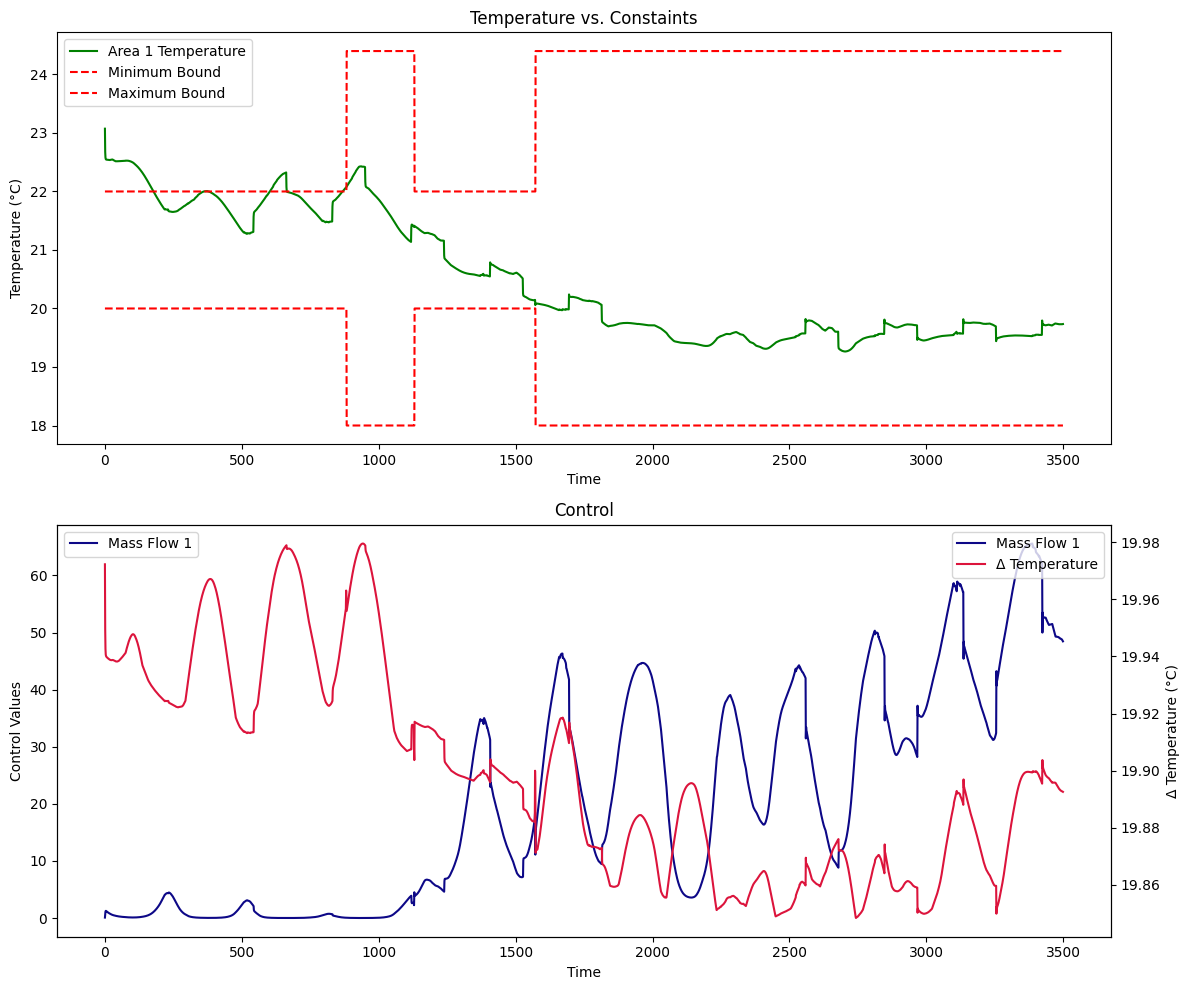

In [88]:
def plot_control(data, sim=0):
    plt.clf()
    plot = {}
    for key in data:
        plot[key] = data[key].detach().cpu().numpy()

    sample_temp = plot["yn_dn"][sim, :, :]
    sample_LB = plot["LB_dn"][sim, :, 0:1]
    sample_UB = plot["UB_dn"][sim, :, 0:1]
    sample_control = plot["U_dn"][sim, :, :]

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    for v in range(sample_temp.shape[1]):
      axs[0].plot(sample_temp[:, v], label=f'Area {v+1} Temperature', color=target_colors[v])

    axs[0].plot(sample_LB, linestyle="--", label="Minimum Bound", color="red")
    axs[0].plot(sample_UB, linestyle="--", label="Maximum Bound", color="red")

    axs[0].set_title("Temperature vs. Constaints")
    axs[0].set_ylabel("Temperature (°C)")
    axs[0].set_xlabel("Time")
    axs[0].legend()

    lns = []
    for v in range(sample_control.shape[1] - 1):
        ln = axs[1].plot(sample_control[:, v], label=f'Mass Flow {v+1}', color=control_colors[v])[0]
        lns.append(ln)
    
    axs[1].set_title('Control')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Mass Flow (kg/s)')
    
    
    ax2 = axs[1].twinx()
    lns.append(ax2.plot(sample_control[:, -1], label='Δ Temperature', color='crimson')[0])
    ax2.set_ylabel('Δ Temperature (°C)')
    
    labs = [ln.get_label() for ln in lns]
    ax2.legend(lns, labs, loc=1)

    axs[1].set_title('Control')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Control Values')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


plot_control(test_out, sim=3)